In [1]:
pip install pytorch-lightning

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torchmetrics.classification import MulticlassAccuracy
import matplotlib.pyplot as plt
import numpy as np
import math
import os

In [3]:
data_dir = './data'

mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_set = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                        download=True, transform=transform)
test_set  = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                        download=True, transform=transform)

In [4]:
batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

In [5]:
len(train_set), len(test_set)

(50000, 10000)

In [6]:
train_set[100][0].shape

torch.Size([3, 32, 32])

In [7]:
images, labels = next(iter(train_loader))

In [8]:
class Patchify(nn.Module):
    def __init__(self, image_size, num_channels, patch_size, stride, embed_dim):
        super().__init__()

        embed_dim = embed_dim

        assert(image_size % patch_size == 0)

        self.num_patches1D = image_size // patch_size

        self.conv = nn.Conv2d(in_channels=num_channels,
                         out_channels=embed_dim,
                         kernel_size=patch_size,
                         stride=stride)

    def forward(self, img):
        patched = self.conv(img)

        y = patched.flatten(2).transpose(1, 2)

        return y

In [9]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, n_heads):
        super().__init__()

        self.embed_dim = embed_dim
        self.c_attn = nn.Linear(self.embed_dim, 3*self.embed_dim, bias=False)
        self.o_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=False)
        self.n_heads = n_heads

        assert(embed_dim % n_heads == 0)

        self.head_dim = embed_dim // n_heads

    def forward(self, x):
        B, T, C = x.size()

        qkv = self.c_attn(x)

        q, k, v = torch.tensor_split(qkv, 3, dim=2)

        q = q.reshape(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.reshape(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.reshape(B, T, self.n_heads, self.head_dim).transpose(1, 2)


        attn = q @ k.transpose(-1, -2)
        attn = F.softmax(attn, dim=-1) / math.sqrt(k.shape[-1])
        attn = attn @ v
        attn = attn.transpose(1, 2).contiguous().view(B, T, C)

        #attn = F.scaled_dot_product_attention(q, k, v)

        y = self.o_proj(attn)

        return y

In [10]:
class MLP(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()

        self.lin1 = nn.Linear(embed_dim, 4 * embed_dim)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(4 * embed_dim, embed_dim)

    def forward(self, x):
        out = self.lin1(x)
        out = self.lin2(self.relu(out))

        return out

In [11]:
class Block(nn.Module):
    def __init__(self, embed_dim, n_heads):
        super().__init__()

        # Layer Norm 1
        self.norm1 = nn.LayerNorm(embed_dim)

        # Multi-Head Self Attention
        self.attention = SelfAttention(embed_dim, n_heads)

        # Layer Norm 2
        self.norm2 = nn.LayerNorm(embed_dim)

        # Feed Forward Layer
        self.mlp = MLP(embed_dim)

    def forward(self, x):
        # Multi-Head Self Attention with residual connection
        out = self.norm1(x)
        out1 = self.attention(out) + x

        # Feed Forward layer with residual connection
        out2 = self.norm2(out1)
        out2 = self.mlp(out2) + out1

        return out2

In [12]:
class Vit(nn.Module):
    def __init__(self, image_size, num_channels, patch_size, stride, embed_dim, n_heads, n_blocks, n_classes):
        super().__init__()

        self.image_size = image_size

        # Patch Size, for non-overlapping patches, patch_size = stride
        self.patch_size = patch_size

        # Number of patches for overlapping and non-overlapping patches
        self.num_patches = (((image_size - patch_size) // stride) + 1) ** 2

        # Embedding dimension for each image token
        self.embed_dim = embed_dim

        # Number of transformer encoder block
        self.n_blocks = n_blocks

        # Patch Embedding
        self.patchifier = Patchify(image_size, num_channels, patch_size, stride, embed_dim)

        # cls token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Learnable position embedding with cls token
        self.pos_emb = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

        # Transformer blocks
        self.blocks = nn.ModuleList([Block(embed_dim, n_heads) for _ in range(n_blocks)])

        # MLP head for classification
        self.mlp_head = nn.Linear(embed_dim, n_classes)

    def forward(self, imgs):
        # Get Patch Embeddings and attach cls token at the beginning
        out = self.patchifier(imgs)
        out = torch.concat([self.cls_token.expand([imgs.shape[0], -1, -1]), out], dim=1)

        # Add position embedding
        out += self.pos_emb

        # Pass it through the encoder blocks
        for block in self.blocks:
            out = block(out)

        # Get the cls token for classification
        out = self.mlp_head(out[:, 0, :])

        return out


In [ ]:
image_size = 32
num_channels = 3
patch_size = 4
stride = 2  # stride = patch_size for non-overlapping patches
n_heads = 4
n_blocks = 16
n_classes = 10

In [13]:
model = Vit(image_size=32,
            num_channels=3,
            patch_size=4,
            stride=2,
            embed_dim=64,
            n_heads=4,
            n_blocks=16,
            n_classes=10)

In [14]:
images.shape

torch.Size([64, 3, 32, 32])

In [15]:
y = model(images)

y.shape

torch.Size([64, 10])

In [16]:
y.shape

torch.Size([64, 10])

In [17]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params:,}\n")

Number of parameters: 813,962



In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
metric = MulticlassAccuracy(num_classes=10).to(device)

In [20]:
num_epochs = 25

epoch_train_accuracies = []
epoch_test_accuracies = []

epoch_train_losses = []
epoch_test_losses = []

for epoch in range(num_epochs):
    model.train()

    train_losses = []
    train_accuracies = []

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            outputs = model(images)

        model_loss = criterion(outputs, labels)

        loss = model_loss

        loss.backward()

        optimizer.step()

        accuracy = metric(outputs, labels) * 100

        train_losses.append(loss.item())
        train_accuracies.append(accuracy)


    model.eval()

    test_losses = []
    test_accuracies = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)           # [B, num_classes]
        loss = criterion(outputs, labels)

        accuracy = metric(outputs, labels) * 100

        test_accuracies.append(accuracy)
        test_losses.append(loss)

    train_loss = torch.mean(torch.tensor(train_losses))
    test_loss = torch.mean(torch.tensor(test_losses))

    train_accuracy = torch.mean(torch.tensor(train_accuracies))
    test_accuracy = torch.mean(torch.tensor(test_accuracies))

    epoch_train_accuracies.append(train_accuracy)
    epoch_test_accuracies.append(test_accuracy)

    epoch_train_losses.append(train_loss)
    epoch_test_losses.append(test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]  |   Train Loss: {train_loss:.4f}    |   Train Accuracy = {train_accuracy:.2f} %   |   Test Loss = {test_loss:.4f}   |   Test Accuracy = {test_accuracy:.2f} %  ")

Epoch [1/25]  |   Train Loss: 1.5916    |   Train Accuracy = 41.27 %   |   Test Loss = 1.3855   |   Test Accuracy = 48.16 %  
Epoch [2/25]  |   Train Loss: 1.3017    |   Train Accuracy = 52.90 %   |   Test Loss = 1.2575   |   Test Accuracy = 54.13 %  
Epoch [3/25]  |   Train Loss: 1.1855    |   Train Accuracy = 57.31 %   |   Test Loss = 1.1618   |   Test Accuracy = 57.99 %  
Epoch [4/25]  |   Train Loss: 1.1017    |   Train Accuracy = 60.27 %   |   Test Loss = 1.0940   |   Test Accuracy = 60.02 %  
Epoch [5/25]  |   Train Loss: 1.0395    |   Train Accuracy = 62.72 %   |   Test Loss = 1.1091   |   Test Accuracy = 60.07 %  
Epoch [6/25]  |   Train Loss: 0.9769    |   Train Accuracy = 64.88 %   |   Test Loss = 1.0425   |   Test Accuracy = 62.72 %  
Epoch [7/25]  |   Train Loss: 0.9211    |   Train Accuracy = 67.12 %   |   Test Loss = 1.0210   |   Test Accuracy = 62.97 %  
Epoch [8/25]  |   Train Loss: 0.8752    |   Train Accuracy = 68.94 %   |   Test Loss = 0.9922   |   Test Accuracy = 64

In [27]:
torch.save(model.state_dict(), os.path.join(r'/content/drive/MyDrive/Colab Notebooks', 'vit_cifar10.pth'))

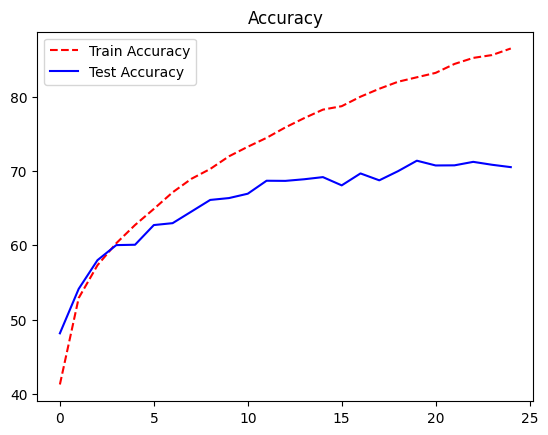

In [24]:
plt.plot(epoch_train_accuracies, 'r--', label='Train Accuracy')  # red dashed line
plt.plot(epoch_test_accuracies, 'b-', label='Test Accuracy')    # blue solid line
plt.title("Accuracy")
plt.legend()
plt.show()

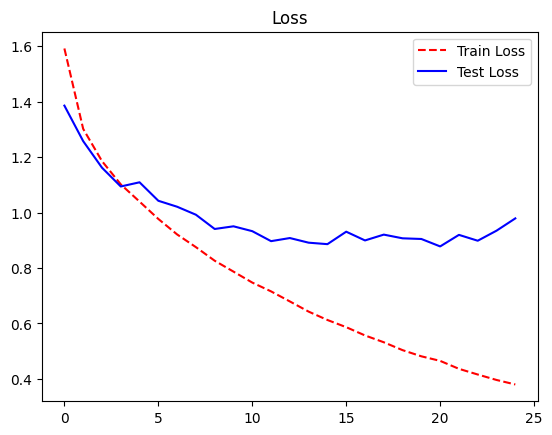

In [25]:
plt.plot(epoch_train_losses, 'r--', label='Train Loss')  # red dashed line
plt.plot(epoch_test_losses, 'b-', label='Test Loss')    # blue solid line
plt.title("Loss")
plt.legend()
plt.show()

In [30]:
max_test_accuracy = max(epoch_test_accuracies).item()

print(f'Max Test Accuracy Achieved = {max_test_accuracy:.2f} %')

Max Test Accuracy Achieved = 71.37 %


In [32]:
min_test_loss = min(epoch_test_losses).item()

print(f'Min Test Loss Achieved = {min_test_loss:.4f}')

Min Test Loss Achieved = 0.8779
